# Wprowadzenie do sieci neuronowych i uczenia maszynowego
## Lab: Podstawowe moduły sieci neuronowych w PyTorch

---

**Autorzy materiałów:** Piotr Baryczkowski, Jakub Bednarek<br>

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji.


## Cel ćwiczeń:

* zapoznanie się z pojęciem **zbioru danych** i jego charakterystyką,
* wykorzystanie podstawowych warstw neuronowych,
* implementacja procesu uczenia sieci neuronowej + *good practices*

In [11]:
import numpy as np
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
CUDA available: True


## Zbiór danych

### Wprowadzenie oraz popularne zbiory danych

Odpowiednie przygotowanie zbioru danych odgrywa znaczącą rolę w uczeniu sieci neuronowych. Zazwyczaj zbiory danych zawierają 3 pozbiory:

* treningowy - wykorzystywany do uaktualniania wag modelu neuronowego,
* walidacyjny - do oceny modelu po każdej **epoce**,
* testowy - do porównania modelu z innymi rozwiązaniami.

**Uwaga:** bardzo często popularne zbiory danych nie posiadają zbioru testowego, ponieważ nie prowadzą tzw. **leaderboard**.

Najpopularniejsze zbiory danych:

* **MNIST**,
* eMNIST,
* Caltech 101/256,
* Cityscapes,
* Kitty,
* LFW Face Dataset,
* ImageNet

Więcej informacji: [wiki](https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research) [kaggle](https://www.kaggle.com/datasets) [google](https://toolbox.google.com/datasetsearch)

### Obsługa zbioru danych w PyTorch

Kod do przetwarzania danych może stać się nieczytelny i trudny do utrzymania; idealnie chcielibyśmy, aby kod związany z naszym zestawem danych był oddzielony od kodu, który odpowiada za uczenie modelu. PyTorch udostępnia dwie klasy do obsługi danych: `torch.utils.data.DataLoader` i `torch.utils.data.Dataset`, które pozwalają na użycie zarówno gotowych zestawów danych, jak i własnych. `Dataset` przechowuje próbki i ich odpowiadające etykiety, a `DataLoader` jest swego rodzaju nakładką na obiekt `Dataset`, umożliwiając łatwy dostęp do próbek - ładowanie danych, dzielenie danych na podzbiory (_ang. batch_). [link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

#### Tworzenie zbioru danych

In [12]:
dataset_size = 10

# zbiór danych składający się z losowych obrazków o rozmiarze (32, 32, 3) oraz etykiet po kolei od 0 do dataset_size
x = [np.random.uniform(size=(32, 32, 3)) for _ in range(dataset_size)]
y = [i for i in range(dataset_size)]

tensor_x = torch.Tensor(x)
tensor_y = torch.Tensor(y)

# utworzenie "iteratora" zbioru danych
dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
dataloader = torch.utils.data.DataLoader(dataset)

<ipython-input-12-2ea1c1efc034>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  tensor_x = torch.Tensor(x)


#### Iterowanie po zbiorze danych

In [13]:
for x, y in dataloader:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([0.])
torch.Size([1, 32, 32, 3]) tensor([1.])
torch.Size([1, 32, 32, 3]) tensor([2.])
torch.Size([1, 32, 32, 3]) tensor([3.])
torch.Size([1, 32, 32, 3]) tensor([4.])
torch.Size([1, 32, 32, 3]) tensor([5.])
torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([7.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([9.])


#### Tasowanie

In [14]:
dataloader_shuffled = torch.utils.data.DataLoader(dataset, shuffle=True)

for x, y in dataloader_shuffled:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([5.])
torch.Size([1, 32, 32, 3]) tensor([0.])
torch.Size([1, 32, 32, 3]) tensor([9.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([7.])
torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([1.])
torch.Size([1, 32, 32, 3]) tensor([3.])
torch.Size([1, 32, 32, 3]) tensor([4.])
torch.Size([1, 32, 32, 3]) tensor([2.])


#### Mapowanie

In [15]:
class MappedDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transform_func):
    self.dataset = dataset
    self.transform_func = transform_func

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    data, label = self.dataset[idx]
    return self.transform_func(data, label)


def map(x, y):
  y = y * 2
  return x, y


dataset_mapped = MappedDataset(dataset, map)
dataloader_mapped = torch.utils.data.DataLoader(dataset_mapped)

for x, y in dataloader_mapped:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([0.])
torch.Size([1, 32, 32, 3]) tensor([2.])
torch.Size([1, 32, 32, 3]) tensor([4.])
torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([10.])
torch.Size([1, 32, 32, 3]) tensor([12.])
torch.Size([1, 32, 32, 3]) tensor([14.])
torch.Size([1, 32, 32, 3]) tensor([16.])
torch.Size([1, 32, 32, 3]) tensor([18.])


#### Filtrowanie

In [16]:
class FilteredDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, threshold):
    self.filtered_data = [
      (data, label) for data, label in dataset if label > threshold
    ]

  def __len__(self):
    return len(self.filtered_data)

  def __getitem__(self, idx):
    return self.filtered_data[idx]


dataset_filtered = FilteredDataset(dataset, 5)

dataloader_filtered = torch.utils.data.DataLoader(dataset_filtered)

for x, y in dataloader_filtered:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([7.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([9.])


#### Grupowanie

In [17]:
dataloader_batch = torch.utils.data.DataLoader(dataset, batch_size=5)

for x, y in dataloader_batch:
  print(x.shape, y)

torch.Size([5, 32, 32, 3]) tensor([0., 1., 2., 3., 4.])
torch.Size([5, 32, 32, 3]) tensor([5., 6., 7., 8., 9.])


#### Składanie wielu operacji na raz

In [18]:
dataset_mix = MappedDataset(dataset, map)
dataset_mix = FilteredDataset(dataset_mix, 6)

dataloader_mix = torch.utils.data.DataLoader(dataset_mix, shuffle=True, batch_size=5)

for x, y in dataloader_mix:
  print(x[0, 0, 0, 0], x.shape, y)

tensor(0.2529) torch.Size([5, 32, 32, 3]) tensor([10., 14., 16., 12., 18.])
tensor(0.5749) torch.Size([1, 32, 32, 3]) tensor([8.])


#### Zadanie 1

Stwórz zbiór danych (bez podziału na zbiory treningowe, walidacyjne i treningowe) składający się z 10000 elementów, zawierający pary (x, y) danych
dla funkcji **sinus**. Dane x niech będą z zakresu [-2 * PI, 2 * PI], y - odpowiadające im wartości funkcji sinus.

Następnie utwórz providera za pomocą PyTorch Dataset API, który będzie:

* tasował dane
* mapował tak, aby dane x, z zakresu [-2 \* PI, 0), były transformowane do przedziału [0, 2 \* PI)

Podpowiedź: (x + 2PI) % 2PI,
* grupował dane w batche o rozmiarze 32

In [19]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset


dataset_size = 10000

x = np.random.uniform(-2 * np.pi, 2 * np.pi, dataset_size)
y = np.sin(x)

class SinusDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


class MappedSinusDataset(Dataset):
    def __init__(self, dataset):
        self.x = (dataset.x + 2 * np.pi) % (2 * np.pi)
        self.y = dataset.y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


dataset = SinusDataset(x, y)
mappedDataset = MappedSinusDataset(dataset)
dataloader = DataLoader(mappedDataset, batch_size=32, shuffle=True)

for x, y in dataloader:
  print(x, y)

tensor([4.2941, 3.8419, 6.2423, 1.4979, 4.3611, 3.7989, 4.3186, 0.9516, 5.9170,
        0.1194, 5.5269, 3.9637, 5.0418, 0.7224, 4.9867, 4.8130, 1.4468, 4.8196,
        1.0438, 4.5062, 4.7007, 0.6138, 3.5567, 0.8051, 0.8740, 4.2914, 1.0148,
        2.3336, 6.0509, 2.7429, 0.9432, 3.4488], dtype=torch.float64) tensor([-0.9138, -0.6444, -0.0409,  0.9973, -0.9389, -0.6110, -0.9235,  0.8144,
        -0.3581,  0.1192, -0.6862, -0.7326, -0.9462,  0.6612, -0.9626, -0.9949,
         0.9923, -0.9943,  0.8643, -0.9788, -0.9999,  0.5760, -0.4033,  0.7209,
         0.7669, -0.9127,  0.8494,  0.7229, -0.2302,  0.3882,  0.8095, -0.3024],
       dtype=torch.float64)
tensor([3.8479, 3.8940, 6.1462, 2.3662, 3.4816, 2.5507, 2.6522, 5.5580, 3.5410,
        3.4699, 5.6089, 2.3871, 0.5358, 4.7644, 5.0921, 1.5950, 0.6638, 1.0347,
        2.7816, 3.2869, 1.3483, 5.5188, 0.6799, 1.2318, 3.5775, 1.0135, 1.9352,
        1.2416, 0.1888, 0.2826, 5.4812, 5.8771], dtype=torch.float64) tensor([-0.6490, -0.6834, -0.13

### Popularne zbiory danych

Biblioteka PyTorch zawiera gotowe funkcje wczytujące dla niektórych zbiorów danych. Większość gotowych zbiorów danych możemy znaleźć w bibliotece *torchvision*. Tutaj możesz znaleźć dokładną listę dostępnych zbiorów danych - [link](https://pytorch.org/vision/stable/datasets.html)

Jednym z popularniejszych zbiorów danych jest MNIST. Jest to zbiór zawierający cyfry pochodzące z pisma odręcznego wraz z ich przypisanymi etykietami ('1', '2', etc.). Poniżej przykładowe pobranie i wykorzystanie zbioru MNIST.

In [20]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 55.1MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.00MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.65MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



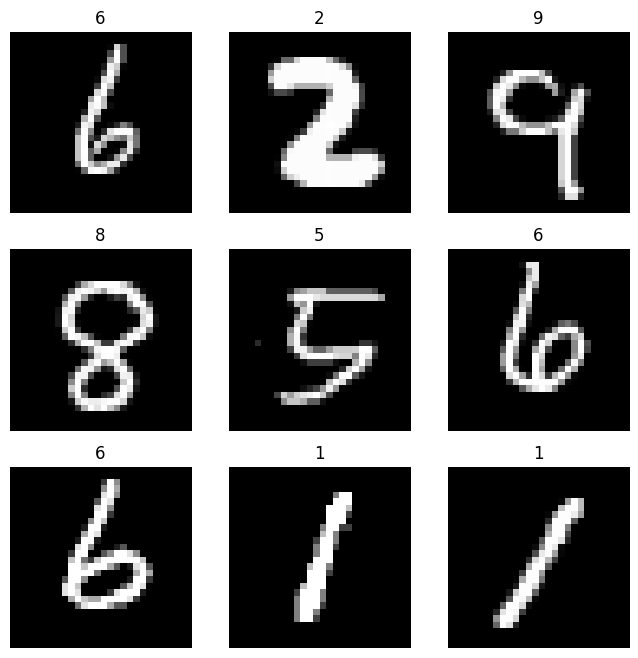

In [21]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Podstawowe warstwy neuronowe

Przy projektowaniu sieci neuronowych możemy wyróżnić podstawowe operacje (warstwy), które się powtarzają. Dla wygody, PyTorch zawiera gotowe implementacje najprostszych z nich, oraz udostępnia interfejsy do tworzenia własnych, bardziej skomplikowanych.

Operacje możemy podzielić na:
* **uczalne** - zawierające zmienne uczalne (np. *w* i *b* w warstwie w pełni połączonej),
* **nieuczalne** - takie, które wykonują pewne charakterystyczne działania na danych, jednak nie potrzebują do tego zmiennych, które będą uczone w trakcie propagacji gradientu.

Poniżej zaprezentowane zostały popularne operacje uczalne i nieuczalne.

**Uwaga**
Wszystkie operacje są reprezentowane jako klasy.

### Uczalne



Dzięki predefiniowanym warstwom nie ma potrzeby samodzielnej deklaracji nowych zmiennych. Wszystkie zmienne uczone są deklarowane (zgodnie z implementacją danej warstwy) wewnątrz obiektu, a następnie przechowywane.

Do zmiennych uczonych można dostać się poprzez własność *state_dict* (lub *parameters*).

In [22]:
m = torch.nn.Linear(5, 5)

m.state_dict()

OrderedDict([('weight',
              tensor([[-0.0835, -0.0408,  0.1652, -0.1334, -0.1482],
                      [-0.0456, -0.0639,  0.1025,  0.0614,  0.4407],
                      [-0.2095,  0.3622,  0.3745, -0.1900,  0.0638],
                      [-0.3256,  0.0985,  0.1870,  0.3035,  0.2873],
                      [ 0.0011, -0.3265, -0.1563, -0.1206,  0.3233]])),
             ('bias', tensor([-0.0377, -0.3673,  0.3538,  0.2628,  0.1427]))])

#### Linear

Jest to warstwa w pełni połączona, która pobiera jako wejście wektor i produkuje na wyjściu wektor o długości równej rozmiarowi warstwy (liczby neuronów).

In [23]:
# definicja warstwy
linear1 = torch.nn.Linear(8, 2)

# inferencja
x = torch.ones([8])
y = linear1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

# zmienne uczone
state_dict = linear1.state_dict()
print(f"Wagi w warstwie linear: {state_dict['weight']}")
print(f"Bias'y w warstwie linear: {state_dict['bias']}")

torch.Size([8]) torch.Size([2])
Wagi w warstwie linear: tensor([[-0.0565,  0.1205, -0.1301, -0.2843,  0.2264, -0.0664, -0.1932,  0.1730],
        [-0.0548, -0.1152, -0.2931,  0.3168, -0.0376, -0.2192, -0.1915, -0.3073]])
Bias'y w warstwie linear: tensor([0.3289, 0.1519])


#### Convolution

Warstwa w pełni połączona dobrze sprawdza się przy danych jednowymiarowych. W przypadku danych wielowymiarowych (jak obrazy) korzystanie z nich byłoby bardzo kosztowne obliczeniowo. Aby wykonać pojedynczą operację *Linear* z 128 neuronami na obrazie o rozmiarach (256, 256, 3) należałoby zadeklarować  256 * 256 * 3 * 128 = 25165824 zmiennych uczonych.

Popularnym rozwiązaniem efektywnego przetwarzania danych wielowymiarowych są operacje konwolucji ([link do wizualizacji](https://github.com/vdumoulin/conv_arithmetic)). Konwolucja (inaczej splot) w sieciach neuronowych intuicyjnie jest, tak samo jak *Linear*, kombinacją liniową danego podobszaru danych wielowymiarowych i zmiennych uczonych (inaczej *kernel*).

Konwolucja w PyTorch posiada szereg parametrów takich jak:
* liczba kanałów wejściowych - liczba kanałów w obrazie wejściowym,
* liczba kanałów wyjściowych - liczba kanałów "wyprodukowana" przez konwolucję,
* kernel_size - rozmiar kernela,
* stride - "rozstrzał" przetwarzanego podobszaru (patrz link do github),
* padding - dopełnienie dodane do wszystkich czterech stron danych wejściowych. Domyślnie: 0,

W porównaniu do przykładu przytoczonego powyżej, konwolucja z 128 filtrami, rozmiarem kernela równym (3, 3), dla takich samych danych wejściowych zawierałaby 3 * 3 * 3 * 128 = 3456, czyli ponad 7281 (!) razy mniej niż w przypadku *Linear*. Ponadto, w przetwarzaniu danych, w których zachodzą lokalne zależności (na obrazie sąsiadujące piksele reprezentują zazwyczaj ten sam obiekt) konwolucja sprawdza się o wiele lepiej niż *Linear*.

In [24]:
# definicja warstwy
conv1 = torch.nn.Conv2d(128, 128, (3, 3), (2, 2), 1)

# inferencja (przy pierwszym wywołaniu warstwy Linear1 zostaną stworzone zmienne uczone)
x = torch.ones([10, 128, 128, 3])
y = conv1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

# zmienne uczone
state_dict = conv1.state_dict()
print(f"Wagi w warstwie conv: {state_dict['weight'].shape}")
print(f"Bias'y w warstwie conv: {state_dict['bias'].shape}")

torch.Size([10, 128, 128, 3]) torch.Size([10, 128, 64, 2])
Wagi w warstwie conv: torch.Size([128, 128, 3, 3])
Bias'y w warstwie conv: torch.Size([128])


### Nieuczalne

Warstwy nieuczalne zazwyczaj wykonują pewne operacje techniczne, typu zmiana kształtu, skalowanie danych, lub są wykorzystywane w **regularyzacji** (o czym będzie mowa na kolejnych zajęciach).

#### Pooling

Jest to jedna z popularniejszych metod regularyzacji, polegająca na wykonaniu pewnej operacji na małym wycinku danych. Przykładowo MaxPooling2D, podobnie jak konwolucja 2D (patrz wizualizacje), wybiera podobszar obrazu o jakichs wymiarach (np. 2x2) a następnie wybiera maksymalny obiekt z tego okna, tworząc nowy obraz (np. zmniejszony 2-krotnie). Istnieją również inne metody poolingu:

* average - z okna obliczana jest średnia,
* median - z okna obliczana jest mediana,
* minimum - z okna wybierana jest najmniejsza wartość,
* itp.

In [25]:
# definicja warstwy
mp1 = torch.nn.MaxPool2d((2, 2), (2, 2))

# inferencja (przy pierwszym wywołaniu warstwy Linear1 zostaną stworzone zmienne uczone)
x = torch.ones([10, 128, 128, 3])
y = mp1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

torch.Size([10, 128, 128, 3]) torch.Size([10, 128, 64, 1])


#### Flatten

Flatten jest prostą funkcją spłaszczającą **każdy element w batchu**. Przykładowo dla grupy 10 obrazów o pewnych wymiarach wyprodukowanych zostanie 10 wektorów (spłaszczonych do wektorów obrazów).

In [26]:
# definicja warstwy
ft1 = torch.nn.Flatten()

# inferencja (przy pierwszym wywołaniu warstwy Linear1 zostaną stworzone zmienne uczone)
x = torch.ones([10, 128, 128, 3])
y = ft1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

torch.Size([10, 128, 128, 3]) torch.Size([10, 49152])


## Proces uczenia sieci neuronowej

Proces uczenia sieci neuronowych składa się z kilku części. Po inicjalizacji modelu oraz zbioru danych następuje uczenie modelu składające się z wielu **epok**. Epoka to pojedyncze przeiterowanie po całym zbiorze danych (podzbiory treningowe i walidacyjne). Przy czym model jest uczony (bład jest propagowany) tylko na zbiorze treningowym. **Nigdy na zbiorach walidacyjnym i testowym.** Proces uczenia sieci neuronowej składa się (najczęściej) następujących części:

1. Inicjalizacja modelu,
2. Inicjalizacja zbioru danych,
3. Pętla treningowa,
  1. Uczenie na zbiorze treningowym (raz!),
  2. Ocena modelu na zbiorze walidacyjnym,
4. Ocena modelu na zbiorze testowym (opcjonalne)

#### Inicjalizacja modelu

**Uwaga:** Jeśli model składa się z następujących po sobie operacji, można opakować go dla wygody w strukturę *Sequential*, tak jak pokazano poniżej.

In [27]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [28]:
import torch.nn as nn
from torch.nn.modules.activation import ReLU


class MyModel(nn.Module):
    def __init__(self) -> None:
        """Model który na wejściu otrzymuje obraz a na wyjściu produkuje skalar

        W skład modelu wchodzą 3 warstwy konwolucyjne o rozmiarach 64, 32, 16 (out_channels),
        każda z rozmiarem kernela 5x5 oraz stride 2x2 (czyli obraz po każdej warstwie będzie 2 razy mniejszy)
        potem następuje spłaszczenie obrazu do wektora i przetwarzanie warstwami w pełni połączonymi.
        Wszystkie warstwy (oprócz wyjściowej) korzystają z funkcji aktywacji 'relu'
        """
        super(MyModel, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=2, padding=1),
            ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=1),
            ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=1),
            ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            ReLU(),
            nn.Linear(in_features=32, out_features=10),
            ReLU(),
            nn.Linear(in_features=10, out_features=10),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        return self.linear_relu_stack(x)


model = MyModel()
print(model)

MyModel(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
)


#### Inicjalizacja zbioru danych

Jako zbiór danych wykorzystany zostanie zaprezentowany wcześniej zbiór **MNIST**.

In [29]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [30]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

### Proces uczenia sieci neuronowej

In [31]:
learning_rate = 1e-3
batch_size = 32
epochs = 5

In [32]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.273502  [   32/60000]
loss: 0.976741  [ 3232/60000]
loss: 0.213019  [ 6432/60000]
loss: 0.564454  [ 9632/60000]
loss: 0.492142  [12832/60000]
loss: 0.388744  [16032/60000]
loss: 0.118974  [19232/60000]
loss: 0.109978  [22432/60000]
loss: 0.192020  [25632/60000]
loss: 0.440202  [28832/60000]
loss: 0.082127  [32032/60000]
loss: 0.184081  [35232/60000]
loss: 0.126854  [38432/60000]
loss: 0.180201  [41632/60000]
loss: 0.129346  [44832/60000]
loss: 0.108557  [48032/60000]
loss: 0.099509  [51232/60000]
loss: 0.233862  [54432/60000]
loss: 0.084031  [57632/60000]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.093853 

Epoch 2
-------------------------------
loss: 0.188183  [   32/60000]
loss: 0.133125  [ 3232/60000]
loss: 0.189446  [ 6432/60000]
loss: 0.146065  [ 9632/60000]
loss: 0.306429  [12832/60000]
loss: 0.069693  [16032/60000]
loss: 0.037345  [19232/60000]
loss: 0.026712  [22432/60000]
loss: 0.065519  [25632/60000]
loss: 0.196084  [28832/60000

#### Zadanie 2

Stwórz sieć neuronową składającą się z:

* 3 warstw konwolucyjnych (kernel size = 5, liczba filtrów = 128, 64, 32, **bez stride (stride=1)**, aktywacja = relu, **padding='1'**)
* 3 warstw Max Pooling-u, każda znajdująca się za kolejną warstwą konwolucyjną (pool size = 2, **stride = 2**, padding=1, funkcja aktywacji: relu) (tzn. Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> ...),
* 3 warstw w pełni połączonych (rozmiary: 512, 128, **liczba klas**, funkcja aktywacji: relu)

Przetestuj swoją sieć na następujących zbiorach danych:

* Cifar 10
* Cifar 100

In [34]:
import numpy as np
import torch
import torch.nn as nn

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
CUDA available: True


In [35]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(NeuralNetwork, self).__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1), # kernel_size=2, bo dwukrotne zmniejszesznie między warstwami konwolucyjnymi
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Flatten(),
            nn.Linear(32 * 4 * 4, 512), # przyznaje się, że to udało się za trzecim razem dopiero, po 32 * 5 * 5 ;  32 * 3 * 3... aż do prawidłowego
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x: torch.Tensor):
        return self.blocks(x)


model = NeuralNetwork(10)
print(model)


NeuralNetwork(
  (blocks): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [41]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize, Resize

# TODO - init dataset
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Tu da się znacznie polepszyć accuracy samą zmianą transformacji danych - dodaniem normalizacji
"""
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
"""

"""
# TODO - init dataset
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
"""

Files already downloaded and verified
Files already downloaded and verified


'\n# TODO - init dataset\ntraining_data = datasets.CIFAR100(\n    root="data",\n    train=True,\n    download=True,\n    transform=ToTensor()\n)\n\ntest_data = datasets.CIFAR100(\n    root="data",\n    train=False,\n    download=True,\n    transform=ToTensor()\n)\n'

In [37]:
from torch.utils.data import DataLoader

batch_size = 32

# TODO - init dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# for X, y in train_dataloader:
#     print(f"Rozmiar: {X.shape}")
#     break

In [42]:
# TODO - train networks
learning_rate = 1e-3
epochs = 3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 0.723911  [   32/50000]
loss: 0.885632  [ 3232/50000]
loss: 0.601796  [ 6432/50000]
loss: 0.787015  [ 9632/50000]
loss: 0.831954  [12832/50000]
loss: 1.088925  [16032/50000]
loss: 0.635155  [19232/50000]
loss: 0.863496  [22432/50000]
loss: 0.998816  [25632/50000]
loss: 0.674964  [28832/50000]
loss: 0.572999  [32032/50000]
loss: 1.248334  [35232/50000]
loss: 1.045289  [38432/50000]
loss: 0.973638  [41632/50000]
loss: 1.000609  [44832/50000]
loss: 0.647744  [48032/50000]
Test Error: 
 Accuracy: 69.3%, Avg loss: 0.896950 

Epoch 2
-------------------------------
loss: 0.692436  [   32/50000]
loss: 1.014164  [ 3232/50000]
loss: 0.904153  [ 6432/50000]
loss: 0.574029  [ 9632/50000]
loss: 0.906046  [12832/50000]
loss: 0.793115  [16032/50000]
loss: 0.751727  [19232/50000]
loss: 0.639775  [22432/50000]
loss: 0.448045  [25632/50000]
loss: 0.704907  [28832/50000]
loss: 1.512999  [32032/50000]
loss: 0.552552  [35232/50000]
loss: 0.743800  [38432/50000

## Pretrenowane sieci

Biblioteka udostępnia również **pretrenowane** modele. Tzn. takie, które zostały już wyuczone na pewnych zbiorach danych.

Istnieje wiele znanych, pretrenowanych sieci neuronowych:

* ResNet (w wersji 50, 100, itp.),
* Inception (V2, V3),
* VGG (16, 19),
* MobileNet,
* LinearNet

Poniżej zaprezentowany został przykład użycia jednej z nich.

**Uwaga:** wgrywanie plikow działa poprawnie w przeglądarce google chrome. Na przeglądarkach FireFox można bezpośrednio wgrać pliki korzystając z zakładki "files" po lewej strone (rozwijany pasek nawigacji - strzałka w prawo). Taki plik można wczytać bezpośrednio korzystając z: Image.open('path_to_file.png').

**Uwaga:** czasem niezbędne jest dwukrotne wykonanie poniższego skryptu, aby można było skorzystać z widgetu do wgrywania pliku.

In [46]:
from torchvision.models import resnet50, ResNet50_Weights

# Using pretrained weights:
resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet50(weights="IMAGENET1K_V1")
resnet50(pretrained=True)  # deprecated
resnet50(True)  # deprecated

# Using no weights:
resnet50(weights=None)
resnet50()
resnet50(pretrained=False)  # deprecated
resnet50(False)  # deprecated

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Saving cat2.jpg to cat2.jpg


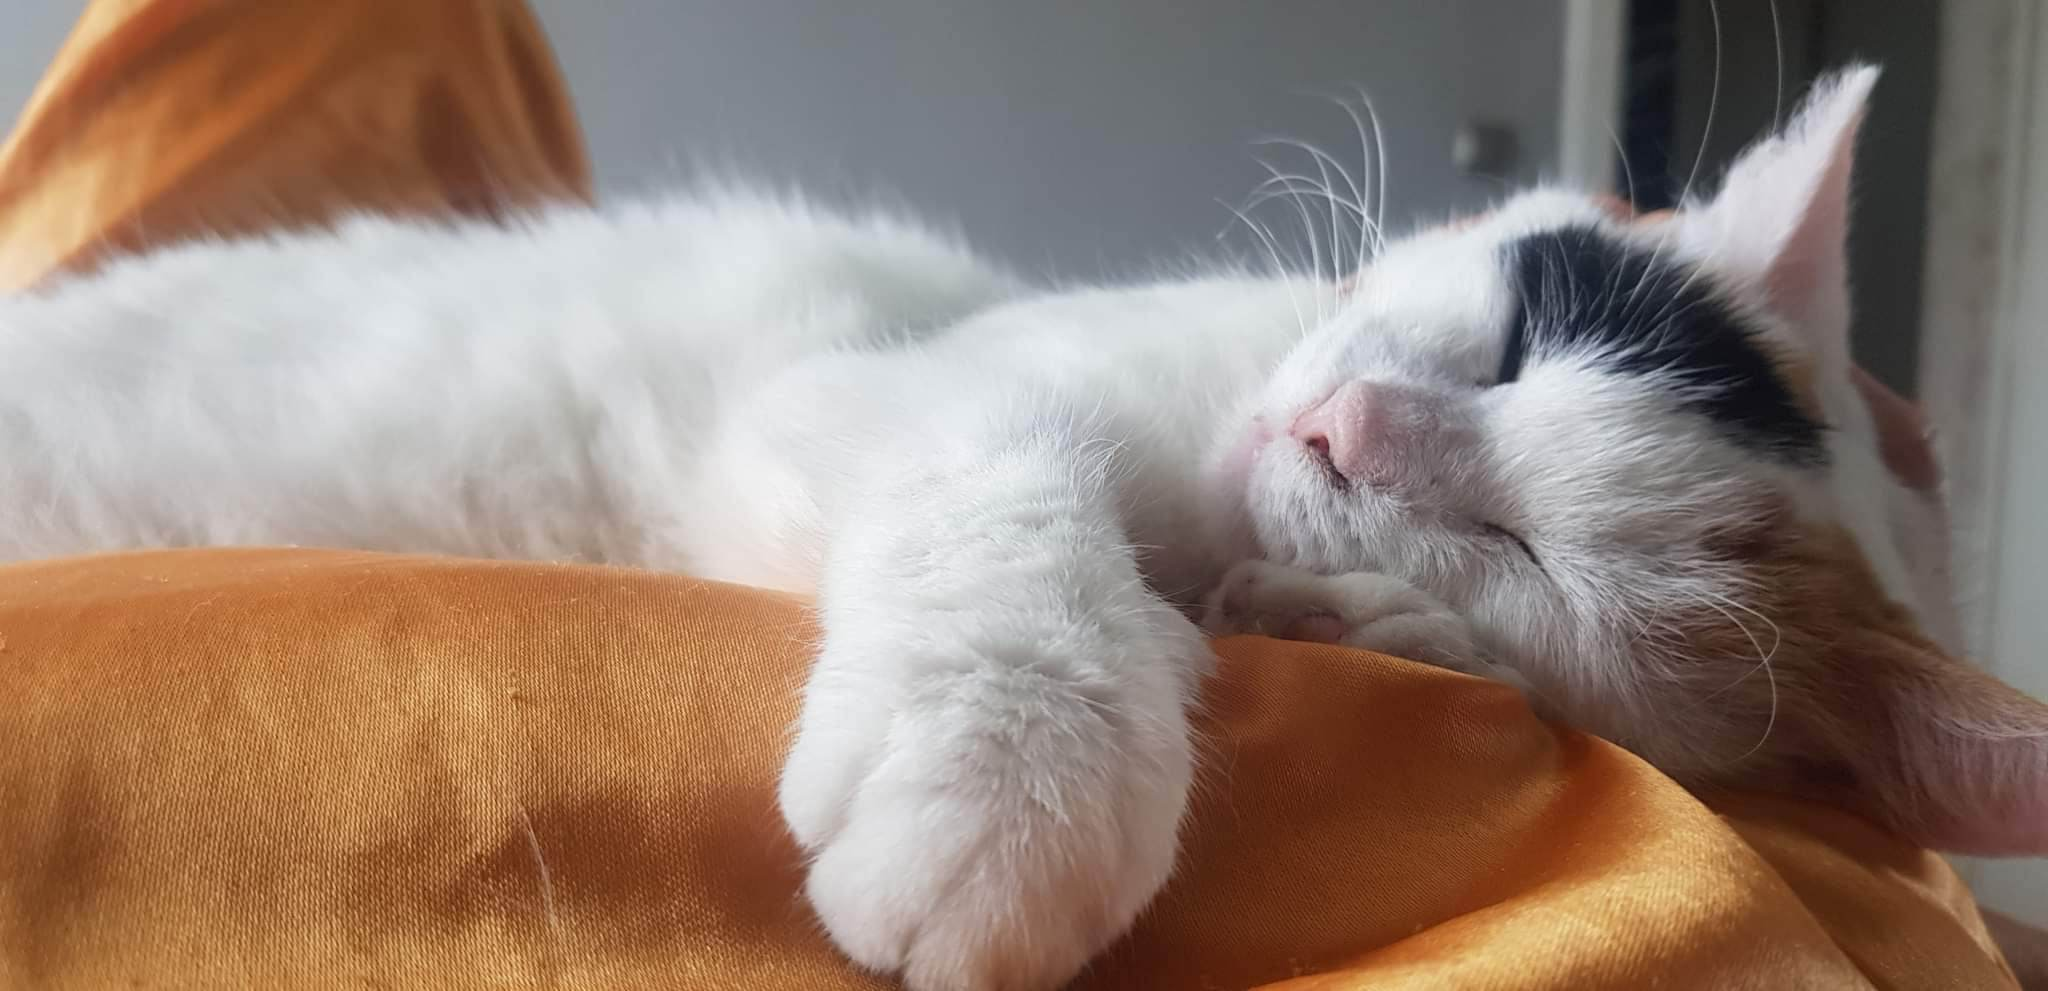

In [50]:
import numpy as np
from google.colab import files
from PIL import Image
from io import BytesIO
import IPython.display

# wybranie sciezki do pliku (jakikolwiek obraz z google)
uploaded = files.upload()

# wyświetlenie obrazu
im = Image.open(BytesIO(uploaded['cat2.jpg']))
# dla przeglądarek FireFox
# im = Image.open('cat.jpg')
IPython.display.display(im)

In [51]:
# przygotowanie obrazka
im_numpy = np.array(im.resize((224, 224)))  # rozmiar który przyjmuje ResNet
im_torch = torch.Tensor(im_numpy).permute(2, 0, 1).unsqueeze(0)

# załadowanie pretrenowanego modelu i jego inferencja
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model.eval()

print(im_torch.shape)
pred = model(im_torch)

# pobranie wyniku z sieci neuronowej
print(torch.argmax(pred, -1).numpy())

torch.Size([1, 3, 224, 224])
[818]


Zgodnie z klasami zawartymi w zbiorze danych ImageNet, odpowiedź 284 oznacza "Kot syjamski".

Przykładowe klasy:

* 21: 'kite',
* 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
* 23: 'vulture',
* 243: 'bull mastiff',
* 244: 'Tibetan mastiff',
* 245: 'French bulldog',
* 282: 'tiger cat',
* 283: 'Persian cat',
* 284: 'Siamese cat, Siamese',
* 285: 'Egyptian cat',

Wszystkie obecne w ImageNet klasy: [link](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

818 - spotlight, spot

#### Zadanie 3

Spróbuj wykorzystać dowolną inną pretrenowaną sieć neuronową, zgodnie z powyższym schematem. Możesz spróbować załadować inny obraz.

Dostępne pretrenowane modele: [link](https://pytorch.org/vision/stable/models.html)

**Uwaga:** zwróć uwagę na rozmiary danych, które przyjmują poszczególne sieci neuronowe.

In [58]:
# inception_or_mobilenet = "mobilenet"  # Tu można zmienić sobie na inny model, ale nie chciało mi się już sprawdzać wymagań co do każdego modelu :)
inception_or_mobilenet = "inception"


from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import inception_v3, Inception_V3_Weights

if inception_or_mobilenet == "mobilenet":
    weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1
    model = mobilenet_v3_large(weights=weights)
elif inception_or_mobilenet == "inception":
    weights = Inception_V3_Weights.IMAGENET1K_V1
    model = inception_v3(weights=weights)
else:
    raise ValueError("Wybierz 'inception' lub 'mobilenet' jako model!")

model.eval()


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 172MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Saving 325600718_547968904019274_2817530236293395186_n.jpg to 325600718_547968904019274_2817530236293395186_n (1).jpg


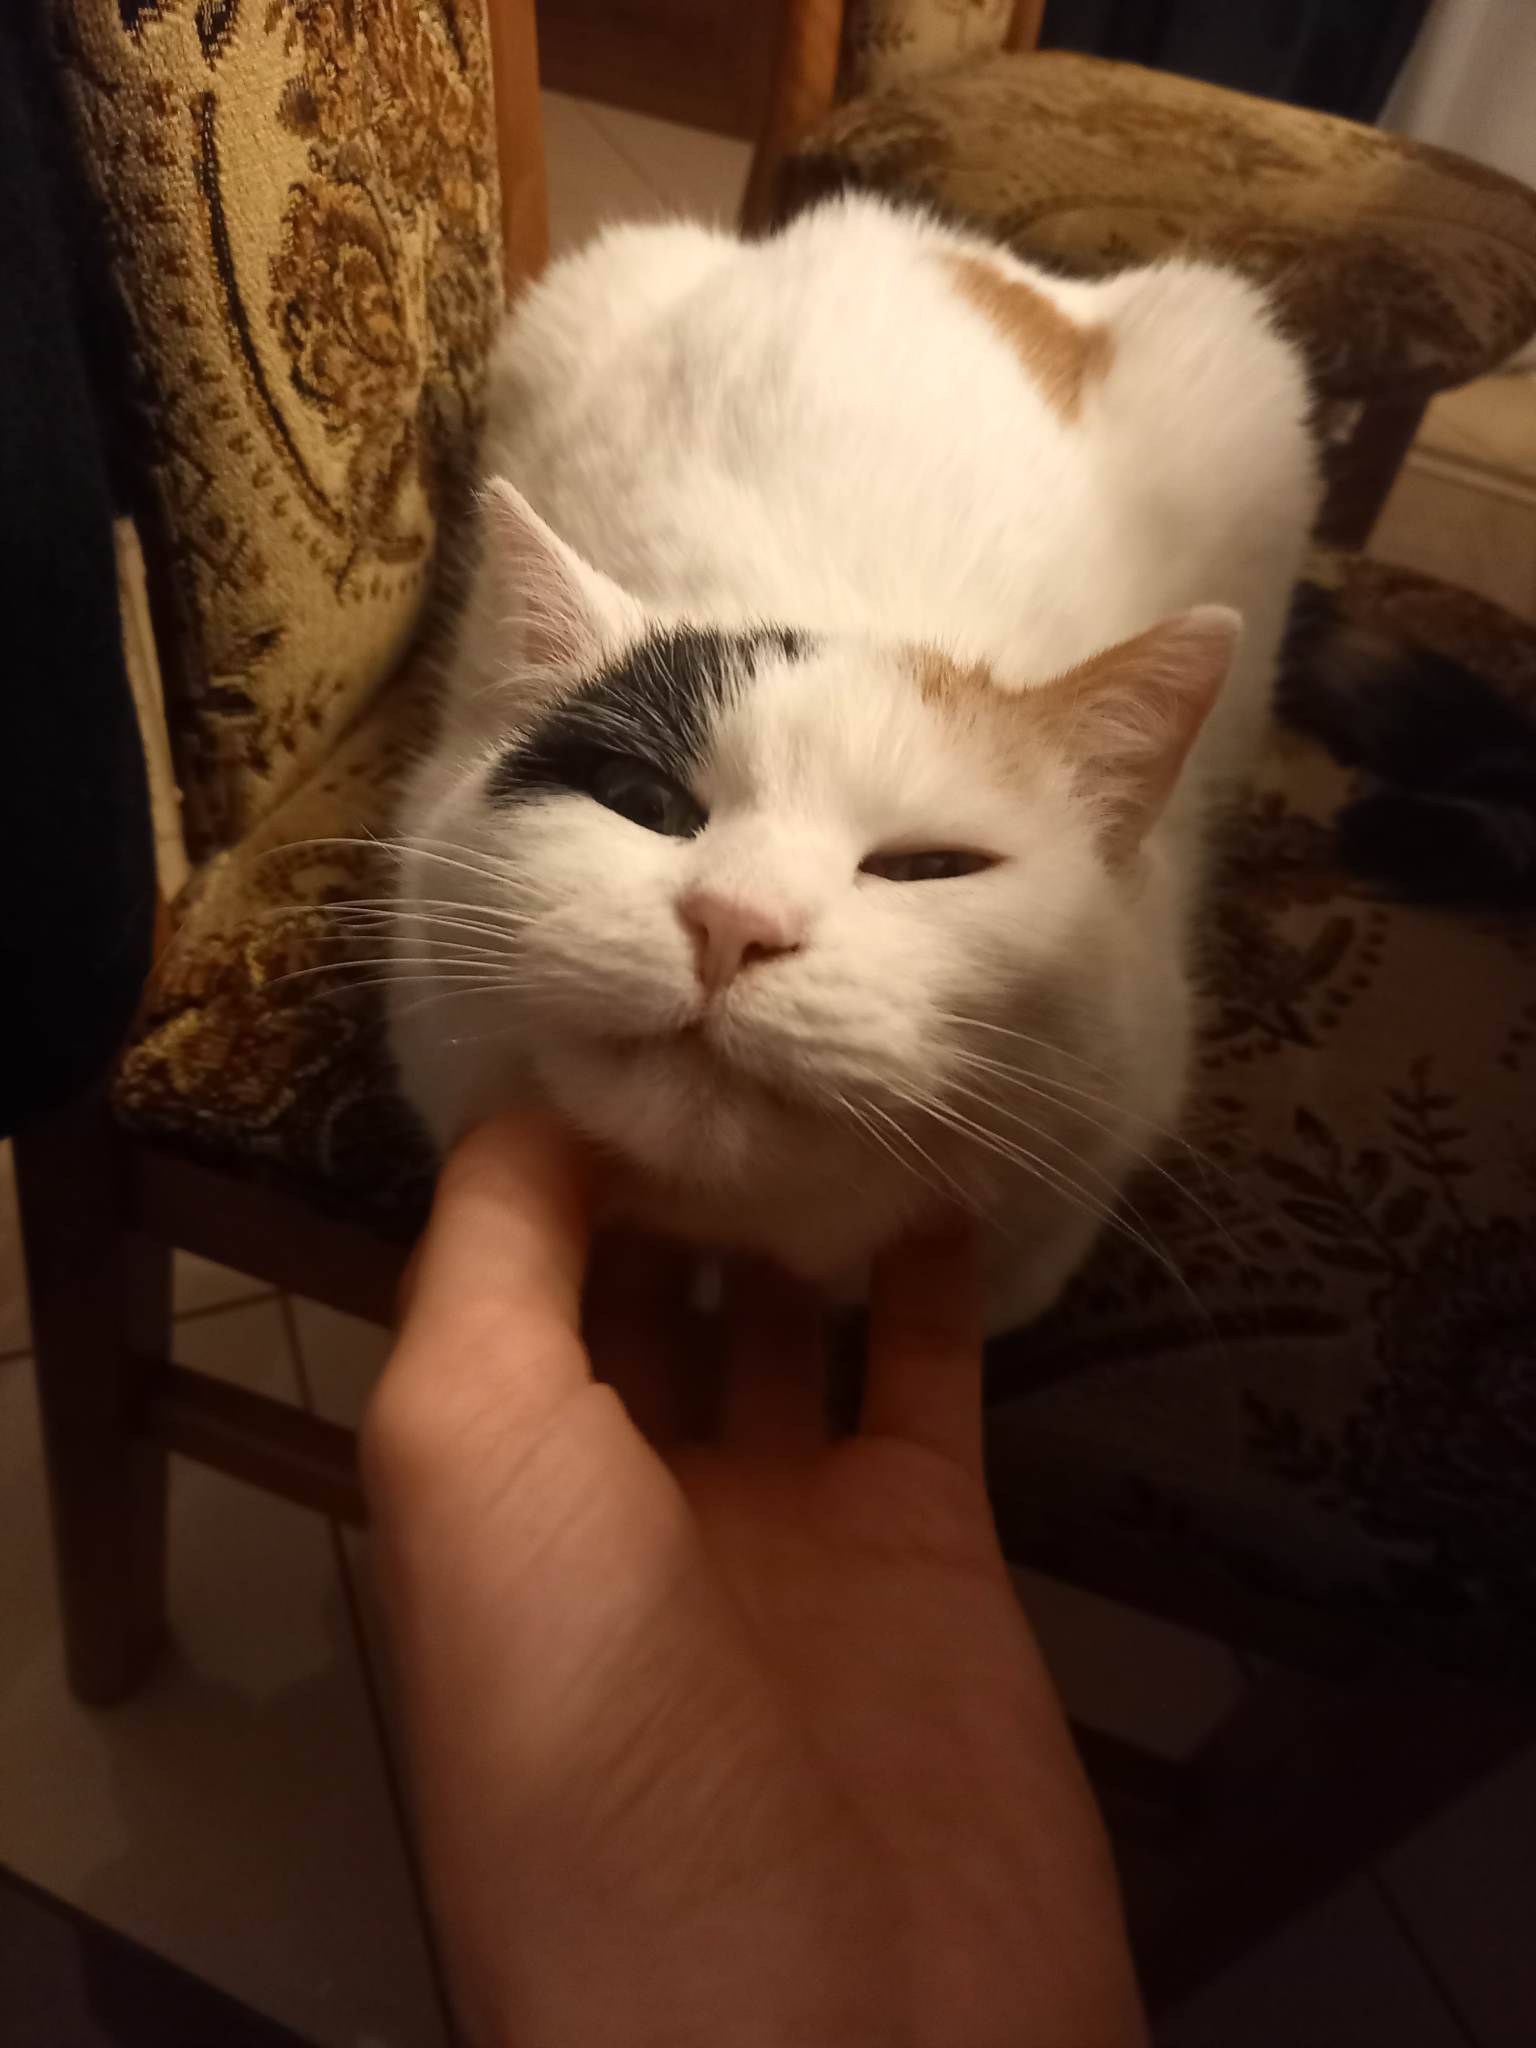

In [59]:
import numpy as np
from google.colab import files
from PIL import Image
from io import BytesIO
import IPython.display


uploaded = files.upload()
im = Image.open(BytesIO(uploaded[next(iter(uploaded.keys()))]))
IPython.display.display(im)


In [60]:
from torchvision import transforms
import torch

transform_cfg = weights.transforms()

if inception_or_mobilenet == "mobilenet":
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # MobileNet wymaga 224x224
        transforms.ToTensor(),
        transform_cfg,
    ])
elif inception_or_mobilenet == "inception":
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),  # Inception wymaga 299x299
        transforms.ToTensor(),
        transform_cfg,
    ])
else:
    raise ValueError("Wybrano niepoprawny model")

im_torch = preprocess(im).unsqueeze(0)
print(f"Rozmiar przetworzonego obrazu: {im_torch.shape}")


Rozmiar przetworzonego obrazu: torch.Size([1, 3, 299, 299])


In [61]:
pred = model(im_torch)

class_id = torch.argmax(pred, -1).item()
class_name = weights.meta["categories"][class_id]

print(f"ID klasy: {class_id}, Nazwa klasy: {class_name}")


ID klasy: 285, Nazwa klasy: Egyptian cat


W przypadku tego jednego konkretnie testowanego zdjęcia to inception sprawdził się lepiej. (Chociaż wymagał też większego obrazka wejściowego niż mobilenet!)


Sprawozdanie, jak zawsze - \
Wojciech Kot, 151879 \
Julia Samp 151755 \